In [5]:
### SKRIPT BY THOMAS BRIAN WINKLER
### PART OF THE ARTICLE "ENEGETICS AND DYNAMICS OF A STABLE BLOCH POINT" by Winkler et al. (2023)
from magnum import *
from math import *
import numpy as np
import random
import os.path
import os
import time
import sys
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def calc(nt, system, sample, write_nucleation=False):
    nar = 100
    naz1 = 30
    naz2 = 20
    a=0.4679*1e-09  # lattice constant of FeGe in m
    random.seed(0)
    t=(naz1+naz2)*a  #total thickness in [m]
    r=nar*a       #radius in [m]
    dia=2*r       #diameter in [m]  
    d = a*(naz1+naz2)/nt  #MM mesh size in [m] 
    nmmz = nt             # number of MM cells in z-direction
    nmm =int(round(dia/d)) # number of MM cells in x- and y-direction

    
    mu0 = 4*np.pi*1e-7   #mu0
    alpha = 0.28         #damping constant
    D = 1.58*1e-3          #DMI [J/m**2]
    A =  8.78*1e-12         #Exchange constant in [J/m]
    Ms=0.384*1e6
    mu=Ms*a**3            #magnetic moment (for HB)
    J=2*A*a
    DISK = Material({
    'id': 'DISK',
    'Ms': Ms,
    'alpha': alpha,
    'A': A,
    'axis1': (0,0,1),
    'axis2': (0,1,0),
    'k_uniaxial': 0.0,
    'k_cubic': 0.0,
    'l':a,
    'mu':mu,
    'J':J})
    relax=0.5 #degree per nanosecond relax condition

    mesh = RectangularMesh((nmm, nmm, nmmz), (d, d, d))
    if sample == "rectangular":
        disk = Cuboid((0,0,0), (nmm*d,nmm*d,nmmz*d))
    if sample == "cylindrical":
        disk = Cylinder((nmm*d/2, nmm*d/2,0.0),(nmm*d/2, nmm*d/2,nmmz*d), nmm*d/2)
    world = World(mesh, Body("disk", DISK, disk))
    solver = create_solver(world, module_list =[StrayField, ExchangeField,  DMIField,ExternalField],
                           finescale = False,  log=False, do_precess = True) # finescale sets either MM (False) or HB mode (True).
   
    folder = system+"/MM_"+sample+"/"
    folderwrite = system+"/MM_"+sample+"/nucleation_"+str(nt)+"/"

    if not os.path.isdir(folder): os.mkdir(folder)
    if not os.path.isdir(folderwrite): os.mkdir(folderwrite)

    #solver.state.M.fill((0,0,Ms))
    
    solver.state.M= (0,0,Ms)
    
    def fillDMIx(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (-D, 0, 0)
        else:
            return (D, 0, 0)

    def fillDMIy(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0, -D, 0)
        else:
            return (0, D, 0)

    def fillDMIz(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0,0, 0)
        else:
            return (0, 0, 0)

    solver.state.Dx = fillDMIx  #fill DMI tensor 
    solver.state.Dy = fillDMIy  #fill DMI tensor
    solver.state.Dz = fillDMIz  #fill DMI tensor
    solver.state.M.normalize(1) # normalize spins to 1 for writing
    filenameinit = system+"_FMinit_nt_"+str(nt)+".omf"
    writeOMF(folder+filenameinit, solver.state.M)
    
    solver.state.M.normalize(1)
    numpymag = solver.state.M.to_numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,2])
    plt.colorbar()
    plt.title("z-magnetization")
    plt.show()
    solver.state.M.normalize(Ms) # renormalize to M_s for energy
    eTFM, eSFM,eAFM, eDFM = solver.state.E_tot, solver.state.E_stray, solver.state.E_exch, solver.state.E_dmi

    if write_nucleation:
        solver.addStepHandler(OOMMFStorage(folderwrite, "M"), condition.EveryNthSecond(2e-11))    
    solver.state.M.normalize(Ms)
    solver.state.H_ext_offs = ((0.0,0.0, 100.0*1e-3/mu0))
    solver.relax(5)
    solver.state.H_ext_offs = ((0.0,0.0, 50.0*1e-3/mu0))
    solver.relax(5)
    solver.state.H_ext_offs = ((0.0,0.0, 10.0*1e-3/mu0))
    solver.relax(5)
    solver.state.H_ext_offs = ((0.0,0.0, 0.0))
    solver.state.M.normalize(Ms)
    solver.relax(relax)

    solver.state.M.normalize(1)
    filename_relaxed = system+"_relaxed_nt_"+str(nt)+".omf"
    writeOMF(folder+filename_relaxed, solver.state.M)    
    
    numpymag = solver.state.M.to_numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,2])
    plt.colorbar()
    plt.title("z-magnetization bottom")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,0])
    plt.colorbar()
    plt.title("x-magnetization bottom")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,-1,2])
    plt.colorbar()
    plt.title("z-magnetization top")
    plt.show()


[   INFO] - LandauLifshitzGilbert module configuration:
[   INFO] -  - H_tot = H_stray + H_exch + H_dmi + H_ext
[   INFO] -  - E_tot = E_stray + E_exch + E_dmi + E_ext
[   INFO] -  - dM/dt = LLGE(M, H_tot)
[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 40x40x10 cells
[   INFO] -   FFT size        : 80x80x20
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--40-40-10--80-80-20--2339-2339-2339.dat
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[   INFO] - ExternalField: Providing model variable H_ext, parameters are H_ext_offs, H_ext_amp, H_ext_freq, H_ext_phase, H_ext_fn
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField, ExternalField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', vo

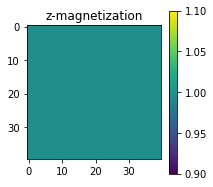

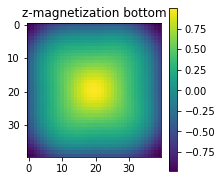

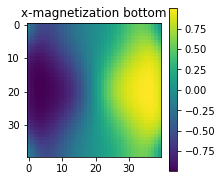

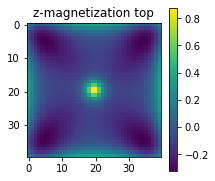

[   INFO] - LandauLifshitzGilbert module configuration:
[   INFO] -  - H_tot = H_stray + H_exch + H_dmi + H_ext
[   INFO] -  - E_tot = E_stray + E_exch + E_dmi + E_ext
[   INFO] -  - dM/dt = LLGE(M, H_tot)
[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 80x80x20 cells
[   INFO] -   FFT size        : 160x160x40
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--80-80-20--160-160-40--1169-1169-1169.dat
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[   INFO] - ExternalField: Providing model variable H_ext, parameters are H_ext_offs, H_ext_amp, H_ext_freq, H_ext_phase, H_ext_fn
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField, ExternalField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk'

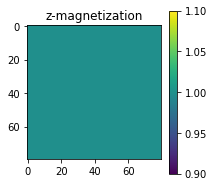

In [ ]:
system = "BV" #chossing configurations Bilayer vortex (BV)
if os.path.isfile(system):
    os.mkdir(system)
write_nucleation  = False
for nt in[10,20,30,40]: # thickness in units of FeGe lattice constant, in study [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90]. 50 equals the atomistic lattice constant.
    for sample in ["rectangular"]:#, "rectangular"]:
        calc(nt, system, sample, write_nucleation)
